# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [3]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [4]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [5]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

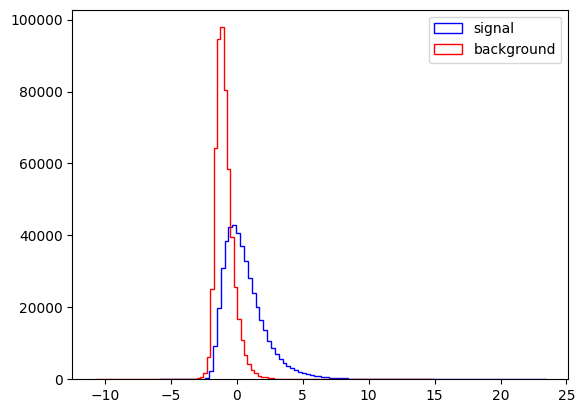

In [6]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

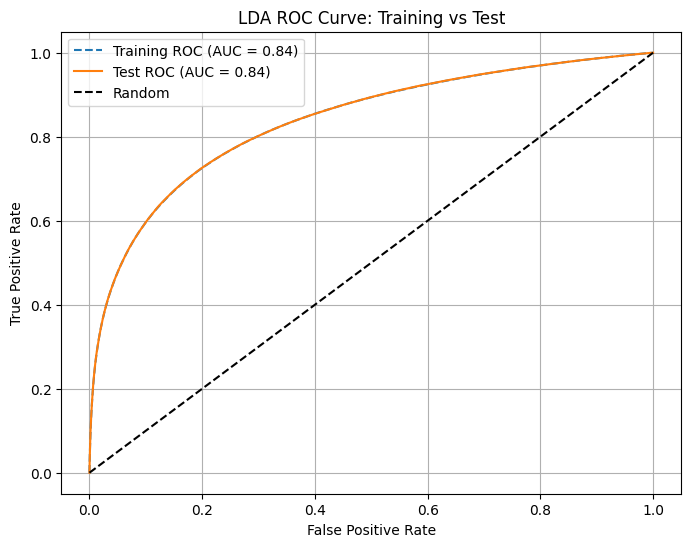

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_Train_proba = Fisher.predict_proba(X_Train)[:, 1]
y_Test_proba = Fisher.predict_proba(X_Test)[:, 1]

# Compute ROC curves
fpr_train, tpr_train, _ = roc_curve(y_Train, y_Train_proba)
fpr_test, tpr_test, _ = roc_curve(y_Test, y_Test_proba)

# Compute AUC
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {auc_train:.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.2f})', linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LDA ROC Curve: Training vs Test')
plt.legend()
plt.grid(True)
plt.show()


#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

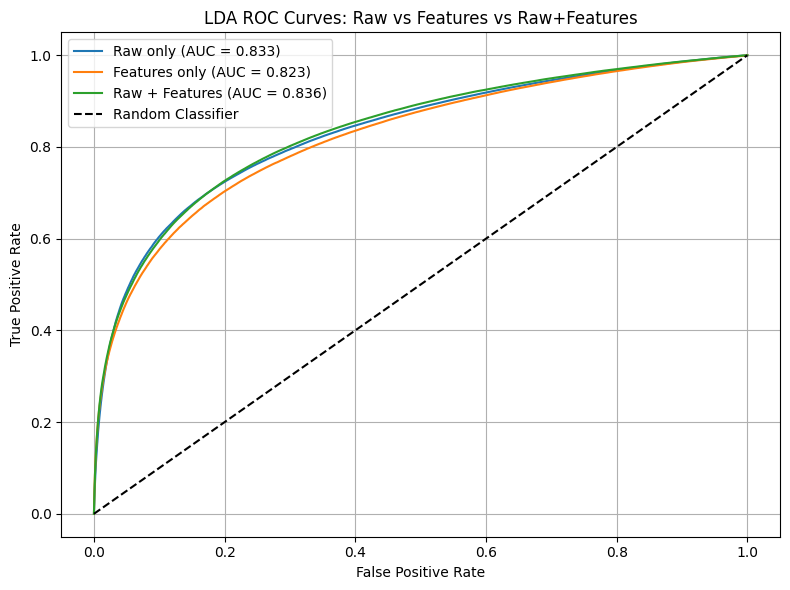

In [8]:
# Split data
N_Train = 4000000
Train_Sample = df[:N_Train]
Test_Sample = df[N_Train:]

y_Train = Train_Sample["signal"]
y_Test = Test_Sample["signal"]

# Define variable groups
RawVars = ["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]          
FeatureVars = list(set(VarNames[1:]).difference(RawVars))    
CombinedVars = RawVars + FeatureVars

# Store curves and labels
models = {
    'Raw only': RawVars,
    'Features only': FeatureVars,
    'Raw + Features': CombinedVars
}

plt.figure(figsize=(8, 6))

for label, vars in models.items():
    X_Train = Train_Sample[vars]
    X_Test = Test_Sample[vars]

    Fisher.fit(X_Train, y_Train)

    # Predict probabilities on test set
    y_test_proba = Fisher.predict_proba(X_Test)[:, 1]

    # ROC & AUC
    fpr, tpr, _ = roc_curve(y_Test, y_test_proba)
    auc_score = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.3f})')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LDA ROC Curves: Raw vs Features vs Raw+Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 7.

**Part A**

-Logistic Regression

-Random Forest

-Gradient Boosting

In [9]:
##Part B
def evaluate_classifier(clf, X_train, y_train, X_test, y_test, label=None, plot=True):
    clf.fit(X_train, y_train)

    # Predict test probabilities
    y_test_proba = clf.predict_proba(X_test)[:, 1]

    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    auc_score = auc(fpr, tpr)

    if plot:
        plt.plot(fpr, tpr, label=f'{label or clf.__class__.__name__} (AUC = {auc_score:.3f})')

    return fpr, tpr, auc_score

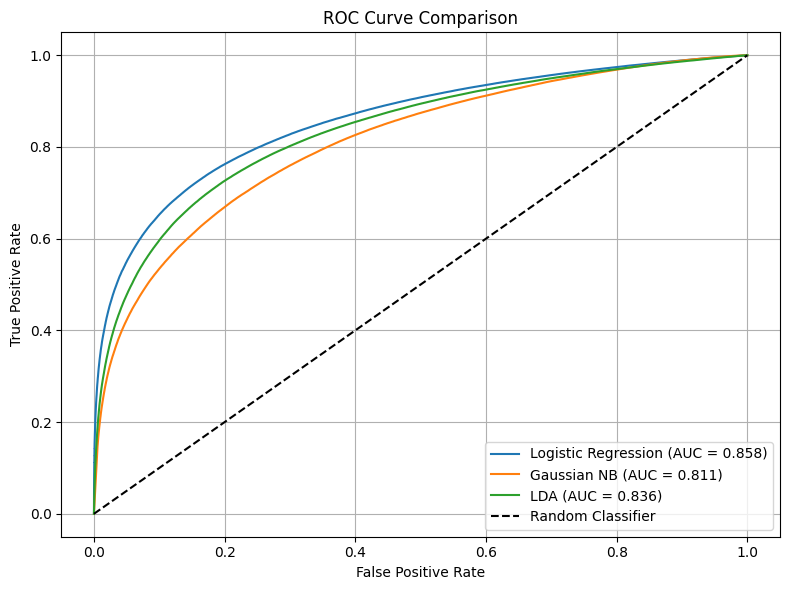

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf_log = LogisticRegression(solver='liblinear', max_iter=300)
clf_nb = GaussianNB()
clf_lda = LinearDiscriminantAnalysis()

# Plot ROC curves
plt.figure(figsize=(8, 6))
evaluate_classifier(clf_log, X_Train, y_Train, X_Test, y_Test, label='Logistic Regression')
evaluate_classifier(clf_nb, X_Train, y_Train, X_Test, y_Test, label='Gaussian NB')
evaluate_classifier(clf_lda, X_Train, y_Train, X_Test, y_Test, label='LDA')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
##Part C
def compute_max_significance(y_true, y_score):
    thresholds = np.linspace(0, 1, 1000)
    best_Z = 0
    best_threshold = 0

    for t in thresholds:
        preds = y_score >= t
        S = np.sum((y_true == 1) & preds)
        B = np.sum((y_true == 0) & preds)

        if S + B > 0:
            Z = S / np.sqrt(S + B)
            if Z > best_Z:
                best_Z = Z
                best_threshold = t

    return best_Z, best_threshold

In [14]:
best_clf = LogisticRegression(solver='liblinear', max_iter=300)
best_clf.fit(X_Train, y_Train)

y_score = best_clf.predict_proba(X_Test)[:, 1]

# Compute max significance
max_Z, optimal_threshold = compute_max_significance(y_Test.values, y_score)
print(f"Max significance Z = {max_Z:.3f} at threshold = {optimal_threshold:.3f}")

Max significance Z = 516.710 at threshold = 0.373


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

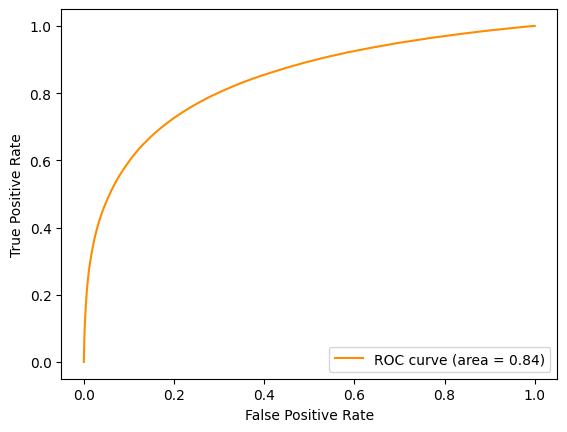

In [15]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [17]:
from sklearn.metrics import (
    roc_curve, auc,
    precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix
)